In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
import glob
import io
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import f1_score
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import Compose, Lambda, ToTensor, Normalize, Resize, RandomCrop, TenCrop, RandomHorizontalFlip
IMAGE_SIZE = [512, 512]
train_files = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/train/*.tfrec"
test_files = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/test/*.tfrec"
val_files = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/*.tfrec"
device = ("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 24
num_prints  = 10
train_size  = 12753
print_freq  = train_size // (batch_size * num_prints) + 1                 
check_freq  = 1
folds = 3

2024-03-19 14:09:48.599012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 14:09:48.599118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 14:09:48.910786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0 
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) 
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64),  
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label 

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [4]:
def tfrecords_to_dataframe(fp, test = False):
    def parse(pb, test = False):
        d = {'id': tf.io.FixedLenFeature([], tf.string), 'image': tf.io.FixedLenFeature([], tf.string)}
        if not test:
            d['class'] = tf.io.FixedLenFeature([], tf.int64)
        return tf.io.parse_single_example(pb, d)

    df = {'id': [], 'img': []} 
    if not test:
        df['lab'] = []
    for sample in tf.data.TFRecordDataset(glob.glob(fp)).map(lambda pb: parse(pb, test)):
        df['id'].append(sample['id'].numpy().decode('utf-8'))
        df['img'].append(sample['image'].numpy())
        if not test:
            df['lab'].append(sample['class'].numpy())
    return pd.DataFrame(df)
def display_images(dataset, n, cols):
    rows = n // cols if n % cols == 0 else n // cols + 1
    plt.figure(figsize = (2 * cols, 2 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        img, lab = dataset[i]
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(str(lab))
        plt.axis('off')
    plt.show()

In [5]:
class Trainset(Dataset):
    def __init__(self, frac = 1):
        super().__init__()
        self.df = tfrecords_to_dataframe(train_files).sample(frac = frac).reset_index(drop = True)
        self.t1 = Lambda(lambda b: Image.open(io.BytesIO(b)))
        self.t2 = Compose([RandomCrop(300), 
                           RandomHorizontalFlip(), 
                           ToTensor(), 
                           Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, i):
        transform = Compose([self.t1, Resize(np.random.randint(300, 641)), self.t2])
        sample = self.df.iloc[i]
        return transform(sample['img']), sample['lab'] 
    
class Evalset(Dataset):
    def __init__(self, frac = 1, test = False):
        super().__init__()
        files = val_files if not test else test_files
        self.df = tfrecords_to_dataframe(files, test).sample(frac = frac).reset_index(drop = True)
        self.transforms = [Compose([Lambda(lambda b: Image.open(io.BytesIO(b))), 
                                    Resize(scale), 
                                    TenCrop(300), 
                                    Lambda(lambda xs: torch.stack([ToTensor()(x) for x in xs])), 
                                    Lambda(lambda xs: torch.stack([Normalize([0.485, 0.456, 0.406], 
                                                                             [0.229, 0.224, 0.225])(x) for x in xs]))])
                           for scale in [372, 568]]
        self.test = test
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        sample = self.df.iloc[i]
        imgs = torch.stack([t(sample['img']) for t in self.transforms])
        return imgs, sample['lab'] if not self.test else sample['id']
 

class EfficientNetB0(nn.Module):
    def __init__(self, n_classes, learnable_modules = ('classifier.1',)):
        super().__init__()
        self.efficientnet_b0 = models.efficientnet_b0(weights = 'DEFAULT')
        self.efficientnet_b0.classifier[1] = nn.Linear(self.efficientnet_b0.classifier[1].in_features, n_classes)
        self.efficientnet_b0.requires_grad_(False)
        modules = dict(self.efficientnet_b0.named_modules())
        for name in learnable_modules:
            modules[name].requires_grad_(True)
        
    def forward(self, x):
        return F.log_softmax(self.efficientnet_b0(x), dim = 1)

In [6]:
train_set    = Trainset()
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
valid_loader = DataLoader(Evalset(frac = 0.20), batch_size = 1, num_workers = 2)
test_loader  = DataLoader(Evalset(test = True), batch_size = 1, num_workers = 2)

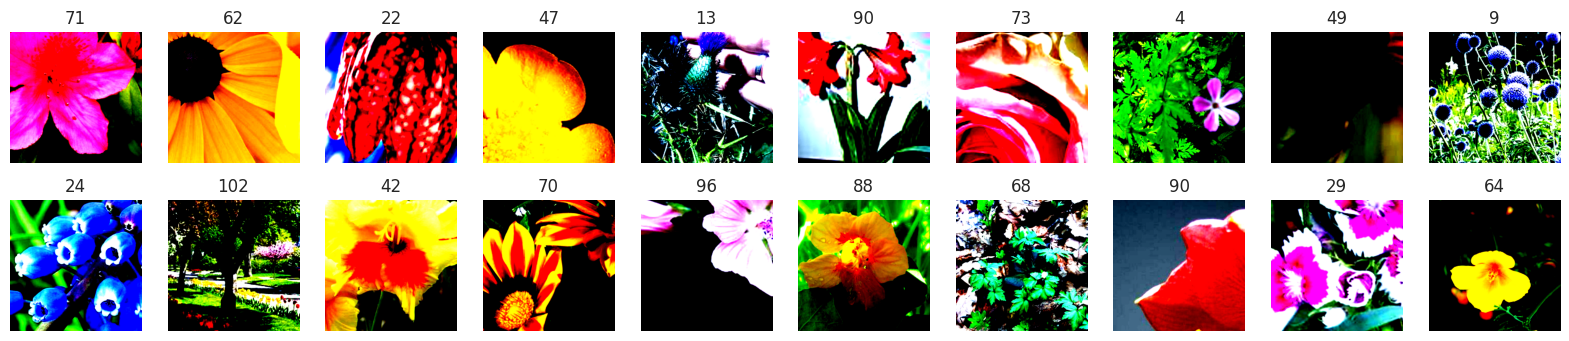

In [7]:
display_images(train_set, n = 20, cols = 10)

In [8]:
model = nn.DataParallel(EfficientNetB0(n_classes = 104, learnable_modules = ('features.5.2', 
                                                                             'features.6', 
                                                                             'features.7', 
                                                                             'features.8', 
                                                                             'classifier')))
model.to(device)

optimizer = torch.optim.Adam(params = [{'params': model.module.efficientnet_b0.features[5][2].parameters()}, 
                                       {'params': model.module.efficientnet_b0.features[6].parameters()}, 
                                       {'params': model.module.efficientnet_b0.features[7].parameters()},
                                       {'params': model.module.efficientnet_b0.features[8].parameters()},
                                       {'params': model.module.efficientnet_b0.classifier.parameters(), 'lr': 1e-3}], 
                             lr = 1e-4, 
                             weight_decay = 1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max = epochs)

loss_fn = F.nll_loss

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 109MB/s] 


In [9]:
losses = []                                                               
valid_f1s = []                                                            
for epoch in range(epochs):
    print()
    print(f'Epoch {epoch}:')
    print('-' * len(f'Epoch {epoch}:'))
    model.train() 
    for i, (x, y) in enumerate(train_loader):
        loss = loss_fn(model(x.to(device)), y.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % print_freq == 0:
            print('Loss {}: {:.3f}'.format(i, loss.item()))
            losses.append(loss.item())
    if epoch % check_freq == 0:
        model.eval()
        valid_true_labs = []
        valid_pred_labs = []
        with torch.no_grad():
            for x, y in valid_loader:
                valid_true_labs.append(y.item())
                mean_logp = model(x.view(-1, 3, 300, 300).to(device)).mean(dim = 0)
                valid_pred_labs.append(torch.argmax(mean_logp).item())
        valid_f1 = f1_score(valid_true_labs, valid_pred_labs, average = 'weighted')
        valid_f1s.append(valid_f1)
        print()
        print('Validation F1: {:.2f}%'.format(valid_f1 * 100))
        torch.save(model.state_dict(), f'./epoch{epoch // check_freq}.pth')
    scheduler.step()


Epoch 0:
--------
Loss 0: 4.671
Loss 54: 2.995
Loss 108: 2.195
Loss 162: 1.401
Loss 216: 2.766
Loss 270: 1.303
Loss 324: 0.809
Loss 378: 0.703
Loss 432: 1.365
Loss 486: 1.123

Validation F1: 87.05%

Epoch 1:
--------
Loss 0: 1.092
Loss 54: 0.794
Loss 108: 0.729
Loss 162: 0.961
Loss 216: 0.645
Loss 270: 0.832
Loss 324: 0.854
Loss 378: 0.331
Loss 432: 1.056
Loss 486: 0.859

Validation F1: 89.88%

Epoch 2:
--------
Loss 0: 0.825
Loss 54: 0.734
Loss 108: 1.231
Loss 162: 0.772
Loss 216: 1.040
Loss 270: 0.232
Loss 324: 0.332
Loss 378: 0.402
Loss 432: 0.875
Loss 486: 0.328

Validation F1: 91.63%

Epoch 3:
--------
Loss 0: 0.498
Loss 54: 0.666
Loss 108: 0.197
Loss 162: 0.691
Loss 216: 0.152
Loss 270: 0.840
Loss 324: 0.459
Loss 378: 0.638
Loss 432: 0.749
Loss 486: 0.476

Validation F1: 92.05%

Epoch 4:
--------
Loss 0: 0.384
Loss 54: 0.545
Loss 108: 0.554
Loss 162: 0.424
Loss 216: 0.304
Loss 270: 0.309
Loss 324: 0.214
Loss 378: 0.341
Loss 432: 0.423
Loss 486: 0.362

Validation F1: 92.55%

Epoc

In [10]:
optimal_epoch = np.argmax(np.array(valid_f1s)) 

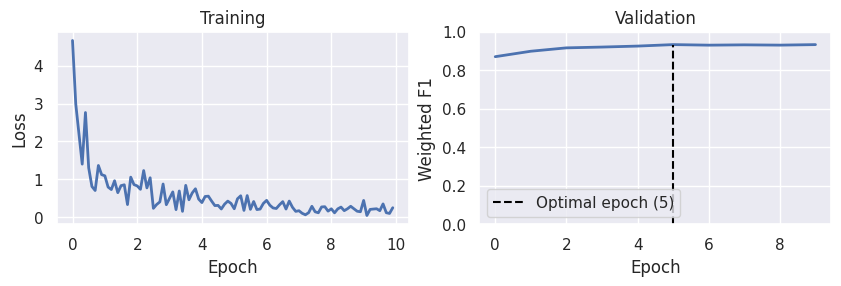

In [11]:
plt.figure(figsize = (10, 2.5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(losses)) / epochs, losses, linewidth = 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(valid_f1s)) * check_freq, valid_f1s, linewidth = 2)
plt.vlines(optimal_epoch * check_freq, 0, valid_f1s[optimal_epoch], colors = 'black', linestyles = 'dashed', label = f'Optimal epoch ({optimal_epoch * check_freq})')
plt.xlabel('Epoch')
plt.ylabel('Weighted F1')
plt.ylim(0, 1)
plt.title('Validation')
plt.legend(loc = 'lower left')
plt.savefig('plot.png')
plt.show()